In [1]:
import os
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#!pip install neattext
import neattext.functions as nfx

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import demoji
demoji.download_codes()

import nltk
# nltk.download('wordnet')
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer

from keras.preprocessing.text import Tokenizer, tokenizer_from_json
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, Dropout, Input, Conv1D, MaxPooling1D, Flatten, GlobalMaxPooling1D
from keras.models import load_model
import tensorflow as tf

/var/folders/24/nqjd68556n7_t8xcfyl1lvpc0000gn/T/ipykernel_48746/2035162933.py:18: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()


## Load the model trained for the emotions prediction

In [2]:
# load model
model = load_model('how_do_you_feel_my_dear/final_model/model.h5')
# summarize model
model.summary()

2022-04-23 09:25:50.066257: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 200)           2180000   
                                                                 
 dropout_27 (Dropout)        (None, 50, 200)           0         
                                                                 
 bidirectional_27 (Bidirecti  (None, 50, 100)          100400    
 onal)                                                           
                                                                 
 dropout_28 (Dropout)        (None, 50, 100)           0         
                                                                 
 bidirectional_28 (Bidirecti  (None, 50, 300)          301200    
 onal)                                                           
                                                                 
 dropout_29 (Dropout)        (None, 50, 300)          

In [3]:
# load the data just downloaded

data = pd.read_csv("how_do_you_feel_my_dear/the_godfather_utterances.csv")
data.head()

,id,text,character,conversation_id,reply_to
0,L593445,You owe the Don a service. He has no doubt th...,HAGEN,L593443,L593444
1,L593443,This is Tom Hagen; I'm calling for Don Corleon...,HAGEN,L593443,NaN
2,L593425,Yes.,HAGEN,L593422,L593424
3,L593423,Good. He never doubted you.,HAGEN,L593422,L593422
4,L593421,"You owe the Don a service. In one hour, not b...",HAGEN,L593420,L593420


In [4]:
def clean_emoji_output(text):
    return re.sub(":", " ", text)

def strip_lowercase(text):
    return text.strip().lower()

# tokenize
tt = TweetTokenizer()

# lemmatize
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text]

# function which cleans texts
def clean_text(data):
    data['clean_text'] = data['text'].apply(nfx.remove_emails)
    data['clean_text'] = data['clean_text'].apply(nfx.remove_numbers)
    data['clean_text'] = data['clean_text'].apply(nfx.remove_urls)
    data['clean_text'] = data['clean_text'].apply(nfx.remove_userhandles)
    data['clean_text'] = data['clean_text'].apply(demoji.replace_with_desc)
    data['clean_text'] = data['clean_text'].apply(clean_emoji_output)
    data['clean_text'] = data['clean_text'].apply(nfx.remove_special_characters)
    data['clean_text'] = data['clean_text'].apply(nfx.remove_bad_quotes)
    data['clean_text'] = data['clean_text'].apply(nfx.remove_html_tags)
    data['clean_text'] = data['clean_text'].apply(nfx.remove_punctuations)
    data['clean_text'] = data['clean_text'].apply(nfx.remove_stopwords)
    data['clean_text'] = data['clean_text'].apply(nfx.remove_multiple_spaces)
    data['clean_text'] = data['clean_text'].apply(strip_lowercase)
    
    data['tokenize'] = data.clean_text.str.lower().apply(tt.tokenize)
    data['tokenize_lemmatized'] = data['tokenize'].apply(lemmatize_text)
    
    # detokenize
    data['final_text'] = data.tokenize_lemmatized.apply(TreebankWordDetokenizer().detokenize)

In [5]:
# clean and shuffle

clean_text(data)
data = shuffle(data, random_state=42)

In [6]:
data.tail()

,id,text,character,conversation_id,reply_to,clean_text,tokenize,tokenize_lemmatized,final_text
71,L593460,He was the one behind Sollozzo?,HAGEN,L593456,L593459,sollozzo,[sollozzo],[sollozzo],sollozzo
106,L593657,Barzini will move against you first.,DON CORLEONE,L593657,NaN,barzini,[barzini],[barzini],barzini
270,L592927,"My brother, Tom Hagen.",MICHAEL,L592925,L592926,brother tom hagen,"[brother, tom, hagen]","[brother, tom, hagen]",brother tom hagen
348,L593591,Is that why you thought you could slap Freddie...,MICHAEL,L593584,L593590,thought slap freddie public,"[thought, slap, freddie, public]","[thought, slap, freddie, public]",thought slap freddie public
102,L593662,Yes.,MICHAEL,L593661,L593661,yes,[yes],[yes],yes


In [7]:
# alphabetical order
# 0: anger
# 1: fear
# 2: joy
# 3: sadness

## Load the tokenizer on which we trained our model
If you use another tokenizer it is not going to work

In [8]:
with open('how_do_you_feel_my_dear/tokenizer/tokenizer.json') as f:
    data_json = json.load(f)

tokenizer = tokenizer_from_json(data_json)

In [9]:
# Convert texts into some numeric sequences and make the length of all numeric sequences equal 

X_seq = tokenizer.texts_to_sequences(data.final_text) 
X_pad = pad_sequences(X_seq, maxlen = 50, padding = 'post') 

X_pad = np.array(X_pad)
X_pad[:3]

array([[1748, 7593, 1138,    7, 1138,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [ 585,  915,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [ 212,  525,  915,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,   

In [10]:
data.final_text[:3]

224    christ tom needed time needed
42                      heard father
285            theyre waiting father
Name: final_text, dtype: object

In [11]:
model.predict(X_pad)

array([[0.07530686, 0.64207655, 0.24416837, 0.03844821],
       [0.0457202 , 0.5290419 , 0.36335048, 0.06188745],
       [0.05299313, 0.14316204, 0.5568054 , 0.24703944],
       ...,
       [0.0365193 , 0.833903  , 0.10705694, 0.02252079],
       [0.6778832 , 0.20148484, 0.07819594, 0.0424361 ],
       [0.30471897, 0.5035038 , 0.07883872, 0.11293846]], dtype=float32)

In [12]:
data['prediction'] = np.argmax(model.predict(X_pad), axis=1)

# alphabetical order
# 0: anger
# 1: fear
# 2: joy
# 3: sadness

code_to_strings = {0: "anger",
                   1: "fear",
                   2: "joy",
                   3: "sadness"}

data["prediction"] = data["prediction"].map(code_to_strings)
data.head()

,id,text,character,conversation_id,reply_to,clean_text,tokenize,tokenize_lemmatized,final_text,prediction
224,L593678,"Christ, Tom; I needed more time with him. I r...",MICHAEL,L593678,NaN,christ tom needed time needed,"[christ, tom, needed, time, needed]","[christ, tom, needed, time, needed]",christ tom needed time needed,fear
42,L593090,You heard about your father?,CLEMENZA,L593090,NaN,heard father,"[heard, father]","[heard, father]",heard father,fear
285,L592894,They're waiting to see my father.,MICHAEL,L592893,L592893,theyre waiting father,"[theyre, waiting, father]","[theyre, waiting, father]",theyre waiting father,joy
302,L593284,Cut it out.,MICHAEL,L593283,L593283,cut,[cut],[cut],cut,fear
56,L592872,"What are you, a dance judge? Go do your job; ...",CLEMENZA,L592871,L592871,dance judge job walk neighborhood okay,"[dance, judge, job, walk, neighborhood, okay]","[dance, judge, job, walk, neighborhood, okay]",dance judge job walk neighborhood okay,fear


<AxesSubplot:>

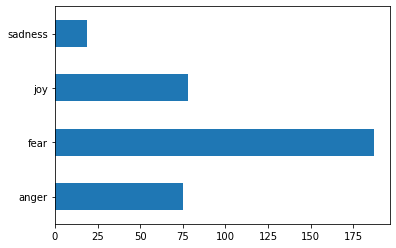

In [13]:
data.prediction.value_counts().sort_index(ascending=True).plot(kind='barh')

In [14]:
# to get the dataframe in the correct shape, unstack the groupby result
df = data.groupby(['character']).prediction.value_counts().unstack()
df['tot'] = data.groupby(['character']).prediction.size()
df['anger'] = round(df['anger']/df['tot']*100)
df['fear'] = round(df['fear']/df['tot']*100)
df['joy'] = round(df['joy']/df['tot']*100)
df['sadness'] = round(df['sadness']/df['tot']*100)
del df['tot']
df

prediction,anger,fear,joy,sadness
character,,,,
CLEMENZA,15.0,50.0,25.0,10.0
DON CORLEONE,16.0,57.0,26.0,NaN
HAGEN,20.0,55.0,18.0,6.0
MICHAEL,22.0,49.0,22.0,6.0
SONNY,25.0,51.0,19.0,5.0


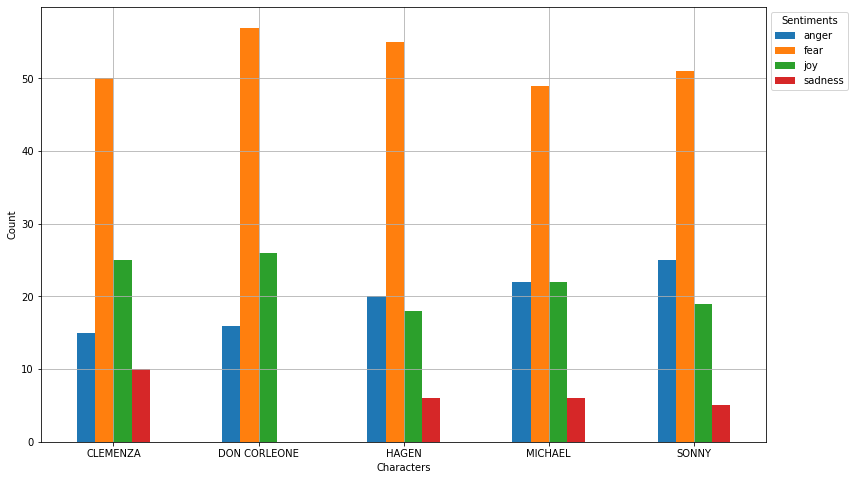

In [15]:
# plot
ax = df.plot(kind='bar', figsize=(13, 8), xlabel='Characters', ylabel='Count', rot=0)
ax.legend(title='Sentiments', bbox_to_anchor=(1, 1), loc='upper left')
plt.grid()

In [16]:
# to get the dataframe in the correct shape, unstack the groupby result
df = data.groupby(['prediction']).character.value_counts().unstack()
df['tot'] = data.groupby(['prediction']).character.size()
df['DON CORLEONE'] = round(df['DON CORLEONE']/df['tot']*100)
df['CLEMENZA'] = round(df['CLEMENZA']/df['tot']*100)
df['HAGEN'] = round(df['HAGEN']/df['tot']*100)
df['MICHAEL'] = round(df['MICHAEL']/df['tot']*100)
df['SONNY'] = round(df['SONNY']/df['tot']*100)
del df['tot']
df

character,CLEMENZA,DON CORLEONE,HAGEN,MICHAEL,SONNY
prediction,,,,,
anger,4.0,13.0,17.0,45.0,20.0
fear,5.0,19.0,19.0,41.0,16.0
joy,6.0,21.0,15.0,44.0,14.0
sadness,11.0,NaN,21.0,53.0,16.0


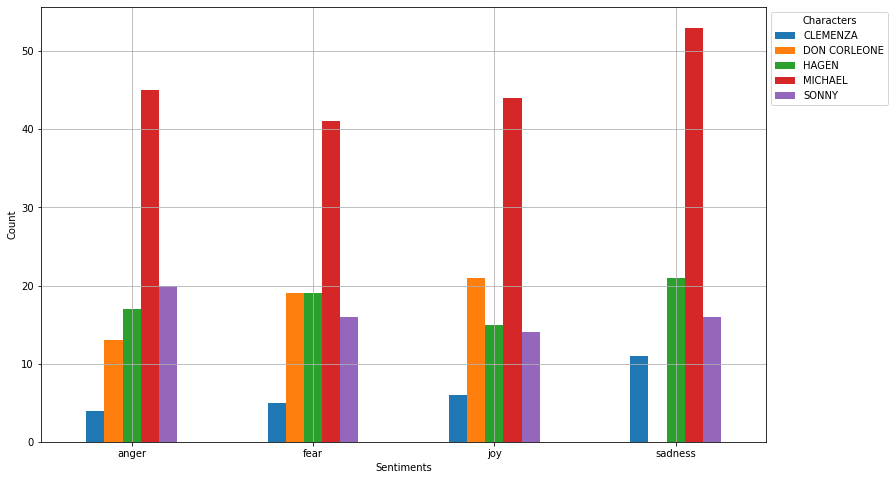

In [17]:
# plot
ax = df.plot(kind='bar', figsize=(13, 8), xlabel='Sentiments', ylabel='Count', rot=0)
ax.legend(title='Characters', bbox_to_anchor=(1, 1), loc='upper left')
plt.grid()

In [18]:
data.to_csv("godfather_emotions.csv")